В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('../datasets/autos.csv')


In [2]:
data['Price'].isna().sum()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Целевой признак - Price. 

Признаки, которые мы будем использовать для обучения включают следующие параметры:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

В первых строках уже видны пропуски значений, а также наблюдаются различия в данных - есть как текстовые, так и цифровы значения. 


In [3]:
# Проверка данных 

data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данной таблице можно увидеть следующие "странные" значения:

- Есть машина с ценой 0
- Продаются имеются машины, с производством в 1000 году (первый автомобиль создан в 1885 г.)
- Имеются 13 месяцев регистрации машины (0-12)
- Для всех данных отсутствуют изображения. 

In [4]:
# Пропуски

data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Исходя из вышеполученных данных будем использовать следующий алгоритм подготовки данных:

***Удаление "бесплатных" машин*** → 

*Удаление "сверх старых" машин* → 

*Замена 0 месяца на медианный* → 

*Удаление столбца с изображениям* → 

*Удаление пропусков*

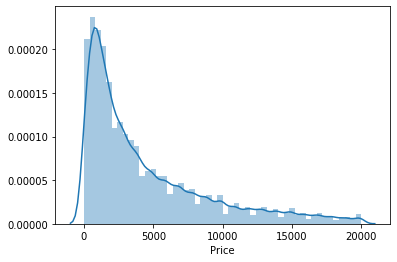

In [5]:
import seaborn as sns

sns.distplot(data['Price'])

Убираем значения < нижнего 5 процентного квантиля. 

In [6]:
low_price = data['Price'].quantile(.05)

data = data.drop(index = data[data['Price'] < low_price].index)

Наше распределение смещено, а также имеются аномальные значения (~0). Далее мы наши признаки логарифмируем, тем самым приведём к нормальному распределению. 

~~*Удаление "бесплатных" машин*~~ → 

***Удаление "сверх старых" машин*** → 

*Замена 0 месяца на медианный* → 

*Удаление столбца с изображениям* → 

*Удаление пропусков*

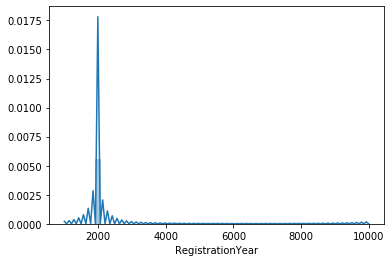

In [7]:
sns.distplot(data['RegistrationYear'])

За счёт больших выбросов распределение очень сильно растянулось. Установим ограничение в 1885 (Создание первого авто) и 2020 (текущий год).

In [8]:
# Минимальное реальное значение даты = 1885. Max = 2020

data = data.query('2020 > RegistrationYear > 1885')

~~*Удаление "бесплатных" машин*~~ → 

~~*Удаление "сверх старых" машин*~~ → 

***Замена 0 месяца на медианный*** → 

*Удаление столбца с изображениям* → 

*Удаление пропусков*

In [9]:
# Замена 0 месяца на медианный. 

data['RegistrationMonth'] = data['RegistrationMonth'].replace(0,data['RegistrationMonth'].median())
data['RegistrationMonth'].unique()

array([ 6,  5,  8,  7, 10, 12, 11,  2,  3,  1,  4,  9])

~~*Удаление "бесплатных" машин*~~ → 

~~*Удаление "сверх старых" машин*~~ → 

~~*Замена 0 месяца на медианный*~~ → 

***Удаление столбца с изображениям*** → 

*Обработка пропусков исходя из типа данных*

In [10]:
# Удаление столбца с изображениями

data.drop(columns='NumberOfPictures', inplace = True)

~~*Удаление "бесплатных" машин*~~ → 

~~*Удаление "сверх старых" машин*~~ → 

~~*Замена 0 месяца на медианный*~~ → 

~~*Удаление столбца с изображениям*~~ → 

***Удаление пропусков***

In [11]:
data.dropna(inplace = True)
data = data.reset_index(drop = True)

data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64

Для данных категорий мы применем технику *LabelEncoder* из модуля *sklearn.preprocessing*, однако перед началом нам нужно избавиться от пропусков. 

В столбце с топливом видно, что есть тип *gasoline* и *petrol*. Отличия в написании (американский / британский стиль). Оба эти значения являются бензином. 

Переименуем *gasoline* в *petrol*

In [12]:
data['FuelType'].replace('gasoline','petrol', inplace = True)

Добавим новый признак - скольно лет машина использовалась (на момент создания объявления).

In [13]:
data['Used'] = pd.to_datetime(data['DateCreated']).dt.year - data['RegistrationYear']

Определим категориальные переменные. Критерием по отбору будет наличие менее 50 уникальных значений. 

In [14]:
from pprint import pprint

# Выделяем категориальные признаки по условию < 50 уникальных признаков. 

nun = data.nunique()

# Массив категориальных признаков

cat = []

# Если < 50 уникальных значений → признак категориальный

for i in range(len(data.columns)):
    if nun[i] < 15:
        cat.append(data.columns[i])
        pprint(f"{data.columns[i]} : {nun[i]} < 50")
print()
print(cat)

'VehicleType : 8 < 50'
'Gearbox : 2 < 50'
'Kilometer : 13 < 50'
'RegistrationMonth : 12 < 50'
'FuelType : 6 < 50'
'NotRepaired : 2 < 50'

['VehicleType', 'Gearbox', 'Kilometer', 'RegistrationMonth', 'FuelType', 'NotRepaired']


In [15]:
data[cat] = data[cat].astype('category')

# 2. Обучение моделей

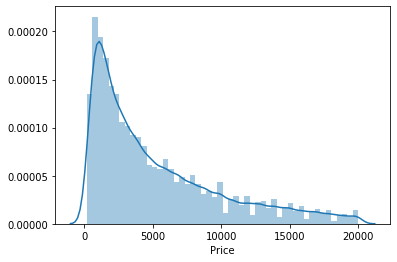

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()

# Convert Model and Brand to Encoded

to_encode = ['Model','Brand']
for category in to_encode:
    data[category] = le.fit_transform(data[category])

#data[['Model','Brand']] = le.fit_transform(data[['Model','Brand']])
        
X = data.drop(['Price','DateCrawled','DateCreated','LastSeen','PostalCode'], axis=1)
# X[cat] = X[cat].astype('int64')
y = data['Price']

sns.distplot(y)

При обработке данных мы выявили, что у нас распределение целевого признака смещено. Мы можем использовать три метода приведения к нормальному распределению:
* Log transformation 
* Square Root Transform
* Box-Cox Transform

Применим первые два метода, так как для третьего нужны значения >0.

'Skew y = 1.2061326640546535, Skew y_log = -0.30693677840659767'


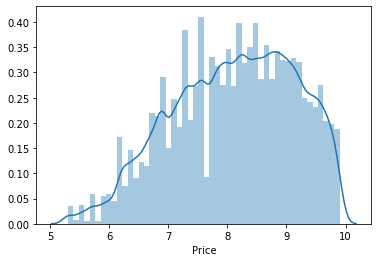

In [17]:
# Log 

y_log = np.log1p(y)
sns.distplot(y_log)

pprint(f"Skew y = {y.skew()}, Skew y_log = {y_log.skew()}")

'Skew y = 1.2061326640546535, Skew y_root = 0.5264898979589262'


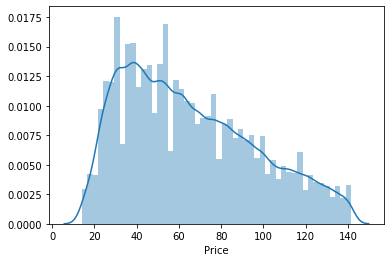

In [18]:
# SQ root 

y_root = np.sqrt(y)
sns.distplot(y_root)

pprint(f"Skew y = {y.skew()}, Skew y_root = {y_root.skew()}")

In [19]:
y = pd.Series(np.log1p(y))

In [24]:
X_train,X_val, y_train,y_val =  train_test_split(X, y, test_size = .4, random_state = 42)
X_val, X_test, y_val,y_test = train_test_split(X_val,y_val, test_size = .5, random_state = 42)


Создаем датасеты для дальнейшей работы. 

In [25]:
# Создаем датасет для обучения, валидаци, теста
import lightgbm as lgb

df_train = lgb.Dataset(data = X_train, label = y_train)
df_val = lgb.Dataset(data = X_val, label = y_val)
df_test = lgb.Dataset(data = X_test, label = y_test)

Указываем стандартные параметры.

In [26]:
params = {
    'objective':'regression',
    'metrics':'rmse',
    'seed':42
}

Обучение с валидацией + построение графика обучения.

Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 0.38111	valid_1's rmse: 0.388778
[200]	training's rmse: 0.368467	valid_1's rmse: 0.381619
[300]	training's rmse: 0.360079	valid_1's rmse: 0.377708
[400]	training's rmse: 0.354021	valid_1's rmse: 0.37556
[500]	training's rmse: 0.34832	valid_1's rmse: 0.373868
[600]	training's rmse: 0.343428	valid_1's rmse: 0.372545
[700]	training's rmse: 0.339114	valid_1's rmse: 0.371349
[800]	training's rmse: 0.335476	valid_1's rmse: 0.370532
Early stopping, best iteration is:
[866]	training's rmse: 0.333241	valid_1's rmse: 0.370211
Plotting metrics recorded during training...


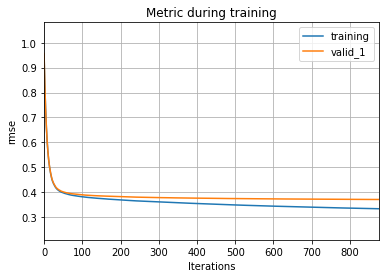

Plotting feature importances...


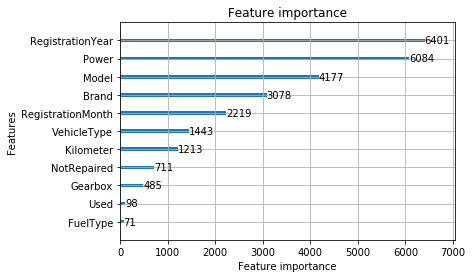

CPU times: user 51.5 s, sys: 2.2 s, total: 53.7 s
Wall time: 8.26 s


In [27]:
%%time
import matplotlib.pyplot as plt


def train(params):
    evals_result = {}
    gbm = lgb.train(params,
                    df_train,
                    num_boost_round=1000,
                    valid_sets=[df_train, df_val],
                    evals_result=evals_result,
                    early_stopping_rounds=10,
                    verbose_eval=100)

    print('Plotting metrics recorded during training...')
    ax = lgb.plot_metric(evals_result, metric='rmse')
    plt.show()

    print('Plotting feature importances...')
    ax = lgb.plot_importance(gbm, max_num_features=100)
    plt.show()
    return gbm

std_param = train(params)

У нас сработала раннаяя остановка. Мы получили значение RMSE на валидации = 0.37. Модели для этого понадобилось ~40 секунд. 

Попробуем изменить параметры и посмотреть на результаты. 

speed_param - попробуем улучшить качество модели

Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 0.38598	valid_1's rmse: 0.390872
[200]	training's rmse: 0.373302	valid_1's rmse: 0.382238
[300]	training's rmse: 0.365867	valid_1's rmse: 0.378475
[400]	training's rmse: 0.360301	valid_1's rmse: 0.376064
[500]	training's rmse: 0.35578	valid_1's rmse: 0.374411
[600]	training's rmse: 0.351635	valid_1's rmse: 0.373003
[700]	training's rmse: 0.348151	valid_1's rmse: 0.371808
[800]	training's rmse: 0.345157	valid_1's rmse: 0.370834
[900]	training's rmse: 0.342494	valid_1's rmse: 0.370276
[1000]	training's rmse: 0.339958	valid_1's rmse: 0.369566
[1100]	training's rmse: 0.337818	valid_1's rmse: 0.369026
[1200]	training's rmse: 0.335707	valid_1's rmse: 0.368572
[1300]	training's rmse: 0.333686	valid_1's rmse: 0.368199
[1400]	training's rmse: 0.331806	valid_1's rmse: 0.367725
Early stopping, best iteration is:
[1455]	training's rmse: 0.330848	valid_1's rmse: 0.367498
Plotting metrics recorded during training...


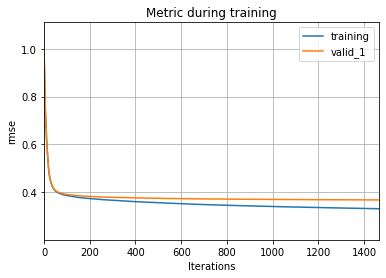

Plotting feature importances...


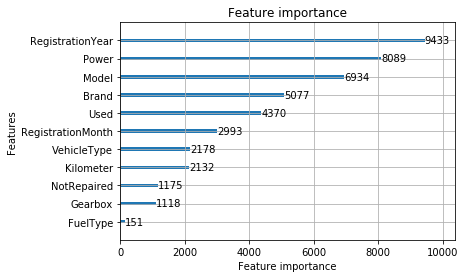

CPU times: user 1min 17s, sys: 3.74 s, total: 1min 21s
Wall time: 12.2 s


In [28]:
%%time
speed_param = {
    'objective':'regression',
    'metrics':'rmse',
    'learning_rate':0.08,
    'num_trees':10000,
    'bagging_fraction': 0.9,
    'seed':42,
    'sub_feature':0.5

}
train(speed_param)

Наша модель за ~ 58 секунд получила качество выше - 0.367

# 3. Анализ моделей

Исходя из вышеполученных значений нам необходимо определить наиболее сбалансированную модель. Стандартная модель (со стандартными параметрами) отработала быстрее и полученное значение RMSE 0.37 является низким. 

Проверим нашу модель на тестовых данных

In [27]:
%%time
from sklearn.metrics import mean_squared_error

predicts = std_param.predict(X_test)

mean_squared_error(y_test, predicts) ** 0.5

CPU times: user 3.04 s, sys: 12.9 ms, total: 3.06 s
Wall time: 410 ms


0.37203323297426444

На тестовых данных получаем значение RMSE 0.372. 